<a href="https://colab.research.google.com/github/mohammad2682/Covid-19/blob/master/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/mohammad2682/Covid19-Dataset

Cloning into 'Covid19-Dataset'...
remote: Enumerating objects: 3253, done.
remote: Total 3253 (delta 0), reused 0 (delta 0), pack-reused 3253
Receiving objects: 100% (3253/3253), 315.60 MiB | 38.99 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (5710/5710), done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import numpy as np 
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import BatchNormalization, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [4]:
import keras
model = keras.models.load_model('gdrive/My Drive/COVID19.h5')

In [5]:
import os
import pandas as pd
disease_types=['CT_COVID', 'CT_NonCOVID']
data_dir = 'Covid19-Dataset/CT-Covid'
train_dir = os.path.join(data_dir)

train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [24]:
train.head()

,File,DiseaseID,Disease Type
0,CT_COVID/2020.03.12.20034686-p17-91-2.png,0,CT_COVID
1,CT_COVID/2020.02.17.20024018-p17-61%4.png,0,CT_COVID
2,CT_COVID/2020.03.04.20026005-p12-1946%2.png,0,CT_COVID
3,CT_COVID/2020.02.25.20021568-p23-108%13.png,0,CT_COVID
4,CT_COVID/2020.02.26.20026989-p34-114_2%1.png,0,CT_COVID


In [6]:
IMAGE_SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [7]:
from tqdm import tqdm
import numpy as np
import cv2

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

746it [00:03, 218.22it/s]


Train Shape: (746, 128, 128, 3)


In [19]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
SEED=42
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=False)

In [9]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 122, 122, 32)      4736      
_________________________________________________________________
dropout_9 (Dropout)          (None, 122, 122, 32)      0         
_________________________________________________________________
activation_3 (Activation)    (None, 122, 122, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 55, 64)        100416    
_________________________________________________________________
dropout_10 (Dropout)         (None, 55, 55, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 64)       

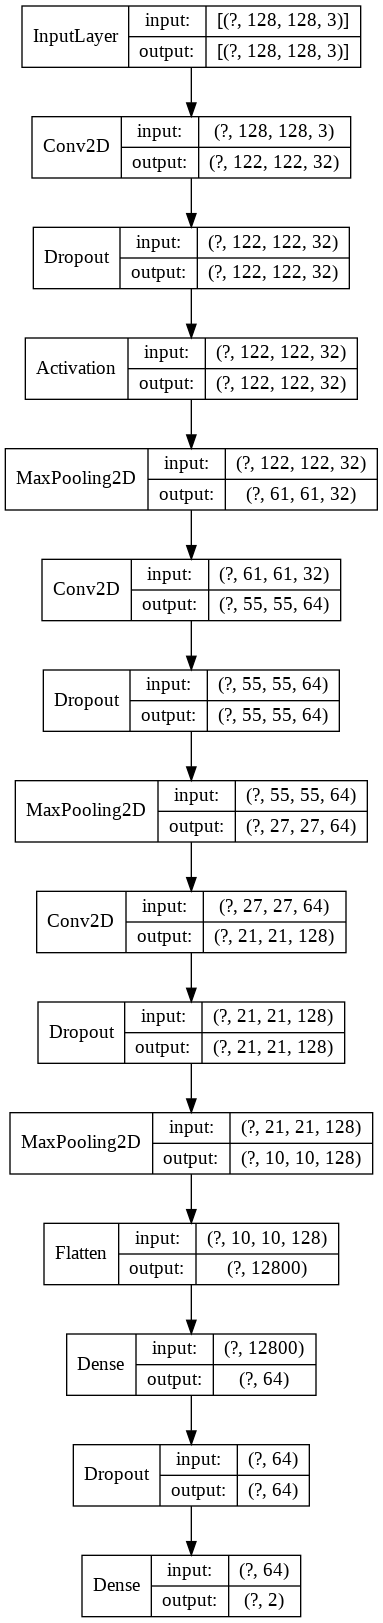

In [18]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [20]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

In [21]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
               steps_per_epoch=596//32,
               epochs=20,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.67437, saving model to model.h5
18/18 - 2s - loss: 0.6852 - accuracy: 0.5691 - val_loss: 0.6744 - val_accuracy: 0.5733
Epoch 2/20

Epoch 00002: val_loss improved from 0.67437 to 0.67365, saving model to model.h5
18/18 - 2s - loss: 0.6464 - accuracy: 0.6135 - val_loss: 0.6736 - val_accuracy: 0.5733
Epoch 3/20

Epoch 00003: val_loss did not improve from 0.67365
18/18 - 2s - loss: 0.6701 - accuracy: 0.5745 - val_loss: 0.6746 - val_accuracy: 0.5733
Epoch 4/20

Epoch 00004: val_loss improved from 0.67365 to 0.67351, saving model to model.h5
18/18 - 2s - loss: 0.6607 - accuracy: 0.6011 - val_loss: 0.6735 - val_accuracy: 0.5733
Epoch 5/20

Epoch 00005: val_loss did not improve from 0.67351
18/18 - 2s - loss: 0.6686 - accuracy: 0.5762 - val_loss: 0.6741 - val_accuracy: 0.5733
Epoch 6/20

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0078125.

Epoch 00006: val_loss did not improve from 0.67351
18/18 - 2s - loss: 0.6524 - accu

Text(0.5, 144.41374999999996, 'Predicted')

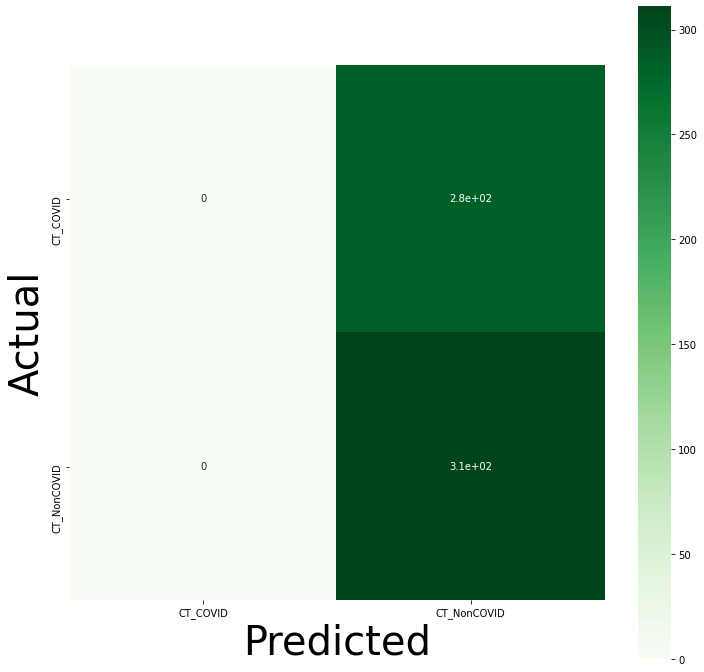

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_train)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_train, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [23]:
Y_val

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.